In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import pandas as pd
from adjustText import adjust_text
import random
import os
from model_structure import get_preprocessing_transforms,BCNN, train_model, evaluate_model

In [2]:
INPUT_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Get transforms
train_transform, val_transform = get_preprocessing_transforms(INPUT_SIZE)

test_data_1_dir = 'data4model_1/test/'
test_data_2_dir = 'data4model_2/test/'
train_data_1_dir = 'data4model_1/train/'
train_data_2_dir = 'data4model_2/train/'

# Load data set
dataset_test_1 = datasets.ImageFolder(test_data_1_dir,transform=val_transform)
dataset_train_1 = datasets.ImageFolder(train_data_1_dir,transform=val_transform)
dataset_test_2 = datasets.ImageFolder(test_data_2_dir,transform=val_transform)
dataset_train_2 = datasets.ImageFolder(train_data_2_dir,transform=val_transform)
additional_set = datasets.ImageFolder('data4model_1/for_extra_test/',transform=val_transform)



additional_loader = DataLoader(additional_set, shuffle=False, batch_size=BATCH_SIZE)
test_loader_1 = DataLoader(dataset_test_1, shuffle=False, batch_size=BATCH_SIZE)
train_loader_1 = DataLoader(dataset_train_1, shuffle=False, batch_size=BATCH_SIZE)
test_loader_2 = DataLoader(dataset_test_2, shuffle=False, batch_size=BATCH_SIZE)
train_loader_2 = DataLoader(dataset_train_2, shuffle=False, batch_size=BATCH_SIZE)

dataSets =  {"Model_1:Train": train_loader_1,
        "Model_1:Test": test_loader_1,
        "Model_2:Train": train_loader_2,
        "Model_2:Test": test_loader_2,
        "Model_1:additional_set": additional_loader
        }

In [4]:
model_1_dir = 'best_model_1.pth'
model_2_dir = 'best_model_2.pth'

In [5]:
# Load the model
model_1 = BCNN().to(DEVICE)
weights = torch.load(model_1_dir, map_location=torch.device(DEVICE))
model_1.load_state_dict(weights)
model_1.eval()

model_2 = BCNN().to(DEVICE)
weights = torch.load(model_2_dir, map_location=torch.device(DEVICE))
model_2.load_state_dict(weights)
model_2.eval()

C:\Users\hskay\AppData\Local\Temp\ipykernel_6660\1438434258.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_1_dir, map_location=torch.device(D

BCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [6]:
for key in dataSets:
    print(key)
    if "Model_1" in key:
        model = model_1
    else:
        model = model_2
    
    results = evaluate_model(model.to(DEVICE), dataSets[key], DEVICE)
    print("Accuracy: ", results[0])
    print("F1 Score: ", results[1])
    print("confusion Matrix: \n",results[3])
    print("\n")

Model_1:Train
Accuracy:  0.9283333333333333
F1 Score:  0.9271926854046733
confusion Matrix: 
 [[1416   84]
 [ 131 1369]]


Model_1:Test
Accuracy:  0.87
F1 Score:  0.8617021276595744
confusion Matrix: 
 [[93  7]
 [19 81]]


Model_2:Train
Accuracy:  0.9436666666666667
F1 Score:  0.9452188006482982
confusion Matrix: 
 [[1373  127]
 [  42 1458]]


Model_2:Test
Accuracy:  0.89
F1 Score:  0.8981481481481481
confusion Matrix: 
 [[81 19]
 [ 3 97]]


Model_1:additional_set
Accuracy:  0.723422860712055
F1 Score:  0.7165172855313701
confusion Matrix: 
 [[2993 1007]
 [1207 2798]]




In [6]:
K_ROUND = 50  # Number of rounds to monitor
activation_values = {"Model_1":{},
                     "Model_2":{}}



In [7]:
def register_hooks(model,model_name):
    hooks = []
    layer_info = {}
    counter = 0

    last_linear_name = None
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Linear):
            last_linear_name = name
    
    global last_layer_name
    last_layer_name = last_linear_name

    for name, layer in model.named_modules():
        #if isinstance(layer, (nn.Conv2d, nn.Linear)):
            # Register hook for the full layer output
            #hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            
            if isinstance(layer, nn.Linear):
                layer_info[name] = {'type': f'{counter:02}-linear',}
                if name == last_linear_name:
                    layer_info[f"{name}_softmax"] = {'type': f'{counter:02}-softmax'}
                hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            elif isinstance(layer, nn.Conv2d):
                layer_info[name] = {'type': f'{counter:02}-conv'}
                hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            # elif isinstance(layer, nn.ReLU):
            #      layer_info[name] = {'type': f'{counter:02}-relu'}
            #      hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            elif isinstance(layer, nn.MaxPool2d):
                 hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
                 layer_info[name] = {'type': f'{counter:02}-maxpool'}
            # elif isinstance(layer, nn.Dropout):
            #     layer_info[name] = {'type': f'{counter}-dropout'}
            elif isinstance(layer, nn.Flatten):
                 layer_info[name] = {'type': f'{counter}-flatten'}
            # elif isinstance(layer, nn.BatchNorm2d):
            #     layer_info[name] = {'type': f'{counter}-batchnorm'}
            # elif isinstance(layer, nn.AdaptiveAvgPool2d):
            #     layer_info[name] = {'type': f'{counter}-adaptiveavgpool'}
            # elif isinstance(layer, nn.Softmax):
            #     layer_info[name] = {'type': f'{counter}-softmax'}
            # else:
            #     layer_info[name] = {'type': f'{counter}-other'}
            counter += 1

    return hooks, layer_info

def get_activation(name, model_name):
    def hook(module, input, output):
        output_relu = torch.nn.functional.relu(output)
        if name == last_layer_name:
            activation_values[model_name][name] = {
                'output': output_relu.detach(),
                'input': input[0].detach(),  # Capturing input
                'weight': module.weight.detach() if hasattr(module, 'weight') else None
            }
            activation_values[model_name][f"{name}_softmax"] = torch.nn.functional.softmax(output_relu.detach(), dim=1)
        else:
            activation_values[model_name][name] = {
                'output': output_relu.detach(),
                'input': input[0].detach(),  # Capturing input
                'weight': module.weight.detach() if hasattr(module, 'weight') else None
            }
    return hook

In [8]:
def select_random_neuron_indices(activations, layer_info, n_neurons=1):
    indices = {}
    all_activated_indices = {}
    previous_layer_contributions = {}
    
    # sorted_layers = sorted(layer_info.keys())
    
    for layer_name in layer_info:
        # WILL DELETE
        if layer_name not in activations:
            continue
            
        layer_data = activations[layer_name]
        if isinstance(layer_data, dict): 
            activation = layer_data['output']
            input_data = layer_data['input']
            weights = layer_data['weight']
            
        # original shape
        original_shape = activation.shape
        
        flattened = activation.view(activation.shape[0], -1)
        positive_indices = np.where(flattened.cpu().numpy().squeeze() > 0)[0]
        
        # all activated indices/inputs whatever it is  for this layer
        all_activated_indices[layer_name] = positive_indices
        

        # debug
        if len(positive_indices) == 0:
            continue
            
        # Select random neurons from activated ones
        selected_indices = np.random.choice(
            positive_indices,
            size=min(n_neurons, len(positive_indices)), # good to think about this
            replace=False # no replace
        )
        
        # calculate contributions from previous layer if weights exist eleminate sacma salak seyler
        if weights is not None and input_data is not None:
            contributions = {}
            for selected_idx in selected_indices:
                # For convolutional layers ([B, 32, 224, 224])
                if len(weights.shape) == 4:  
                    # converting flattened index back to feature map coordinates
                    if len(original_shape) == 4:  # batch, channels, height, width
                        batch_size, channels, height, width = original_shape

                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        channel = selected_idx // (height * width)
                        pos_in_channel = selected_idx % (height * width)
                        h_idx = pos_in_channel // width
                        w_idx = pos_in_channel % width
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        
                        # besure channel is within bounds
                        if channel >= weights.shape[0]:
                            continue
                        
                        # Get weights for this output channel
                        channel_weights = weights[channel]
                        
                        # simplified calculate contribution
                        contribution = torch.tensor(0.0)
                        if input_data.shape[2] > h_idx and input_data.shape[3] > w_idx:
                            contribution = input_data[0, :, h_idx, w_idx].sum() * channel_weights.sum()
                    else:
                        # skiped if shape doesnt match expectations
                        #print(f"Skipping layer {layer_name} due to unexpected shape: {original_shape}")
                        continue
                        
                # for linear layers
                else:  
                    # for linear layers, the flattened index needs to be mapped to output dimension
                    output_dim = weights.shape[0]
                    if selected_idx >= output_dim: # its random operation is wron
                        # Skip if index is out of bounds
                        #print(f"Skipping layer {layer_name} due to out of bounds index: {selected_idx}")
                        continue
                        
                    neuron_weights = weights[selected_idx]
                    contribution = (input_data * neuron_weights).sum()
                
                contributions[int(selected_idx)] = {
                    'weights': weights[min(selected_idx, weights.shape[0]-1)].cpu().numpy(),
                    'input_values': input_data.cpu().numpy(),
                    'contribution': contribution.item() if isinstance(contribution, torch.Tensor) else contribution
                }
            
            previous_layer_contributions[layer_name] = contributions
        
        indices[layer_name] = {
            'neuron_idx': selected_indices,
            'type': layer_info[layer_name]['type'],
            'all_activated_indices': positive_indices,
            'contributions': previous_layer_contributions.get(layer_name, None)
        }
    
    return indices, all_activated_indices, previous_layer_contributions

In [9]:
def compare_model_activations(activation_values_1, activation_values_2, indices1, indices2, layers1, layers2):
    comparison_results = {}
    
    # Get the layer names from Model_1
    for layer_name in layers1:
        if layer_name not in activation_values_1 or layer_name not in activation_values_2:
            continue
            
        data1 = activation_values_1[layer_name]
        data2 = activation_values_2[layer_name]
        
        if not isinstance(data1, dict) or not isinstance(data2, dict):
            continue
            
        input1 = data1['input']
        weights2 = data2['weight']
        #print(weights2)
        #print(layer_name)
        #print(type(weights2))
        bias2 = data2.get('bias', None) #FOR SOFTMAX
        output1 = data1['output']
        
        # Get selected neuron indices
        if layer_name in indices1[0]:
            selected_indices = indices1[0][layer_name]['neuron_idx']
        else:
            #print("Skipping layer", layer_name)
            continue
            
        # results for this layer
        layer_results = {
            'neuron_comparisons': [],
            'mean_difference': 0.0,
            'max_difference': 0.0,
            'min_difference': float('inf')
        }
        
        # Compare selected neurons
        for idx in selected_indices:
            if weights2 is not None:
                # CONV
                if len(weights2.shape) == 4:  # Convolutional layer
                    
                    batch_size, channels, height, width = output1.shape
                    channel = idx // (height*width)
                    pos_in_channel = idx%(height * width)
                    h_idx = pos_in_channel//width
                    w_idx = pos_in_channel%width
                    
                    if channel >= weights2.shape[0]:
                        #print(f"Skipping layer {layer_name} due to out of bounds channel: {channel}")
                        continue
                        
                    # Get actual activation from Model_1
                    actual_activation = output1[0, channel, h_idx, w_idx].item()
                    
                    kernel_size = weights2.shape[2]
                    padding = kernel_size // 2 
                    
                                            # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                                                # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                                                # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                                                # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                                                # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                                                # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                    # Extract input patch
                    in_h_start = max(0, h_idx - padding)
                    in_w_start = max(0, w_idx - padding)
                    in_h_end = min(input1.shape[2],h_idx+kernel_size-padding)
                    in_w_end = min(input1.shape[3],w_idx+kernel_size-padding)
                                            # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                                                # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                                                # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                                                # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                                                # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                                                # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                        # DONT TOUCH THIS PART
                    input_patch = input1[0, :, in_h_start:in_h_end, in_w_start:in_w_end]
                    weight_patch = weights2[channel]
                    
                    # Adjust weight patch size if needed
                    if input_patch.shape != weight_patch.shape[1:]:
                        bad_model_activation = torch.tensor(0.0)
                    else:
                        bad_model_activation = (input_patch * weight_patch).sum()
                    
                    # Add bias if exist
                    if bias2 is not None:
                        bad_model_activation += bias2[channel]
                    
                    # apply ReLU for any case
                    if actual_activation > 0:
                        bad_model_activation = max(0, bad_model_activation)
                    
                else:  # Linear layer
                    #if index is out of bounds
                    if idx >= weights2.shape[0]:
                        continue
                        
                    # Get actual activation from Model_1 (flattened)
                    flattened_output = output1.view(output1.shape[0], -1)
                    actual_activation = flattened_output[0, idx].item()
                    
                    # Calculate expected activation using Model_2 weights
                    neuron_weights = weights2[idx]
                    bad_model_activation = (input1.flatten(start_dim=1) * neuron_weights).sum()
                    
                    # Add bias if available
                    if bias2 is not None:
                        bad_model_activation += bias2[idx]
                    
                    if actual_activation > 0:
                        bad_model_activation = max(0, bad_model_activation)
                
                #converting to scalar if it is a tensor
                if isinstance(bad_model_activation, torch.Tensor):
                    bad_model_activation = bad_model_activation.item()
                    
                #calculate difference
                difference = abs(actual_activation - bad_model_activation)
                
                #comparison for this neuron
                neuron_comparison = {
                    'neuron_idx': int(idx),
                    'actual_activation': actual_activation,
                    'bad_model_activation': bad_model_activation,
                    'difference': difference,
                    'percen_diff': (difference / (abs(actual_activation) + 1e-10)) * 100
                }
                
                layer_results['neuron_comparisons'].append(neuron_comparison)
                
                #statistics
                layer_results['mean_difference'] += difference
                layer_results['max_difference'] = max(layer_results['max_difference'], difference)
                layer_results['min_difference'] = min(layer_results['min_difference'], difference)
            
            #average difference
            if len(layer_results['neuron_comparisons']) > 0:
                layer_results['mean_difference'] /= len(layer_results['neuron_comparisons'])
            else:
                layer_results['mean_difference'] = float('nan')
                layer_results['min_difference'] = float('nan')
            
            comparison_results[layer_name] = layer_results
    return comparison_results
    

In [10]:
def save_comparison_results_to_csv(comparison_results, input_id, round_id, filename="model_comparison_results.csv"):
    rows = []
    for layer_name, layer_data in comparison_results.items():
        mean_diff = layer_data['mean_difference']
        max_diff = layer_data['max_difference']
        min_diff = layer_data['min_difference']
    
        if np.isnan(mean_diff):
            mean_diff = "N/A"
        if np.isnan(min_diff):
            min_diff = "N/A"
    
        if layer_data['neuron_comparisons']:
            for neuron_data in layer_data['neuron_comparisons']:
                row = {
                    'input_id': input_id,
                    'round_id': round_id,
                    'layer_name': layer_name,
                    'neuron_idx': neuron_data['neuron_idx'],
                    'actual_activation': neuron_data['actual_activation'],
                    'bad_model_activation': neuron_data['bad_model_activation'],
                    'difference': neuron_data['difference'],
                    'percent_difference': neuron_data['percen_diff'],
                    'layer_mean_difference': mean_diff,
                    'layer_max_difference': max_diff,
                    'layer_min_difference': min_diff
                }
                rows.append(row)
        else:
            row = {
                'input_id': input_id,
                'round_id': round_id,
                'layer_name': layer_name,
                'neuron_idx': "N/A",
                'actual_activation': "N/A",
                'bad_model_activation': "N/A",
                'difference': "N/A",
                'percent_difference': "N/A",
                'layer_mean_difference': mean_diff,
                'layer_max_difference': max_diff,
                'layer_min_difference': min_diff
            }
            rows.append(row)
    
    df = pd.DataFrame(rows)
    file_exists = os.path.isfile(filename)
    
    if file_exists:
        df.to_csv(filename, mode='a', header=False, index=False)
        #print(f"Results appended to {filename}")
    else:
        df.to_csv(filename, index=False)
        #print(f"Results saved to new file {filename}")
    
    return df

In [11]:
classes = {
    0: 'cat',
    1: 'dog'
}

In [12]:
the_class = 1 # 0 cat or squirrel, 1 dog

In [ ]:
# activation_values = {"Model_1":{},
#                     "Model_2":{}}

In [ ]:
# images = [(img, idx) for idx, (img, label) in enumerate(dataSets["Model_1:Test"].dataset) 
#             if label == 0][:15]
# image = images[0][0]

In [ ]:
# hooks1, layers1 = register_hooks(model_1, "Model_1")
# hooks2, layers2 = register_hooks(model_2, "Model_2")

# with torch.no_grad():
#     pred1 = model_1(image.unsqueeze(0).to(DEVICE))
#     pred2 = model_2(image.unsqueeze(0).to(DEVICE))

# indices1 = select_random_neuron_indices(activation_values["Model_1"], layers1)
# indices2 = select_random_neuron_indices(activation_values["Model_2"], layers2)

# comparison_results = compare_model_activations(activation_values["Model_1"], 
#                                                activation_values["Model_2"], 
#                                                indices1, 
#                                                indices2, 
#                                                layers1, 
#                                                layers2)

# for layer_name, results in comparison_results.items():
#     print(f"\nLayer: {layer_name}")
#     print(f"Mean difference: {results['mean_difference']:.6f}")
#     print(f"Max difference: {results['max_difference']:.6f}")
#     print(f"Min difference: {results['min_difference']:.6f}")

#     print("\nSample neuron comparisons:")
#     for i, comp in enumerate(results['neuron_comparisons'][:5]): 
#         print(f"  Neuron {comp['neuron_idx']}: Actual={comp['actual_activation']:.6f}, "
#               f"Prime activation={comp['bad_model_activation']:.6f}, "
#               f"Diff={comp['difference']:.6f} ({comp['percen_diff']:.2f}%)")
    
#     good_matches = sum(1 for comp in results['neuron_comparisons'] 
#                       if comp['percen_diff'] < 5)  # Consider <5% difference
#     match_percentage = (good_matches / len(results['neuron_comparisons'])) * 100 if results['neuron_comparisons'] else 0
    
#     print(f"Match percentage (within 5% difference): {match_percentage:.2f}%")

# save_comparison_results_to_csv(comparison_results, 0, 0, filename="model_comparison_results.csv")
# for hook in hooks1 + hooks2:
#     hook.remove()

  pic_index:  8004 round:  49

In [14]:
with torch.no_grad():
    images = [(img, idx) for idx, (img, label) in enumerate(dataSets["Model_1:additional_set"].dataset) 
                if label == the_class and model_1(img.unsqueeze(0).to(DEVICE))
                                          .argmax().item() == the_class]

In [ ]:
all_dfs = []

for image, pic_index in images:
    for i in range(K_ROUND):
        activation_values = {"Model_1":{},
                    "Model_2":{}}
        hooks1, layers1 = register_hooks(model_1, "Model_1")
        hooks2, layers2 = register_hooks(model_2, "Model_2")

        with torch.no_grad():
            pred1 = model_1(image.unsqueeze(0).to(DEVICE))
            pred2 = model_2(image.unsqueeze(0).to(DEVICE))

        indices1 = select_random_neuron_indices(activation_values["Model_1"], layers1)
        indices2 = select_random_neuron_indices(activation_values["Model_2"], layers2)

        comparison_results = compare_model_activations(activation_values["Model_1"], 
                                                    activation_values["Model_2"], 
                                                    indices1, 
                                                    indices2, 
                                                    layers1, 
                                                    layers2)

        # for layer_name, results in comparison_results.items():
        #     print(f"\nLayer: {layer_name}")
        #     print(f"Mean difference: {results['mean_difference']:.6f}")
        #     print(f"Max difference: {results['max_difference']:.6f}")
        #     print(f"Min difference: {results['min_difference']:.6f}")

        #     print("\nSample neuron comparisons:")
        #     for i, comp in enumerate(results['neuron_comparisons'][:5]): 
        #         print(f"  Neuron {comp['neuron_idx']}: Actual={comp['actual_activation']:.6f}, "
        #             f"Prime activation={comp['bad_model_activation']:.6f}, "
        #             f"Diff={comp['difference']:.6f} ({comp['percen_diff']:.2f}%)")
            
        #     good_matches = sum(1 for comp in results['neuron_comparisons'] 
        #                     if comp['percen_diff'] < 5)  # Consider <5% difference
        #     match_percentage = (good_matches / len(results['neuron_comparisons'])) * 100 if results['neuron_comparisons'] else 0
            
        #     print(f"Match percentage (within 5% difference): {match_percentage:.2f}%")
        print('\r ',"pic_index: ", pic_index, "round: ",i, end="")
        save_comparison_results_to_csv(comparison_results, pic_index, i, filename=f"model_comparison_results_on_{classes[the_class]}.csv")
        for hook in hooks1 + hooks2:
            hook.remove()

In [13]:
csv_file = "model_comparison_results_on_dog.csv"
df = pd.read_csv(csv_file)

In [14]:
df.head(10)

,input_id,round_id,layer_name,neuron_idx,actual_activation,bad_model_activation,difference,percent_difference,layer_mean_difference,layer_max_difference,layer_min_difference
0,4000,0,features.0,476453.0,0.091859,0.000000,0.091859,100.000000,0.091859,0.091859,0.091859
1,4000,0,features.2,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2,4000,0,features.4,698275.0,0.340996,0.000000,0.340996,100.000000,0.340996,0.340996,0.340996
3,4000,0,features.6,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
4,4000,0,features.8,282062.0,0.003175,0.000000,0.003175,99.999997,0.003175,0.003175,0.003175
5,4000,0,features.10,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
6,4000,0,classifier.1,215.0,1.405092,0.608851,0.796241,56.668265,0.796241,0.796241,0.796241
7,4000,0,classifier.4,1.0,3.215892,1.369533,1.846359,57.413599,1.846359,1.846359,1.846359
8,4000,1,features.0,1582589.0,0.004221,0.000000,0.004221,99.999998,0.004221,0.004221,0.004221
9,4000,1,features.2,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN


In [15]:
df = df[~df['layer_name'].isin(['features.2', 'features.6', 'features.10'])]


In [16]:
df.head(10)

,input_id,round_id,layer_name,neuron_idx,actual_activation,bad_model_activation,difference,percent_difference,layer_mean_difference,layer_max_difference,layer_min_difference
0,4000,0,features.0,476453.0,0.091859,0.000000,0.091859,100.000000,0.091859,0.091859,0.091859
2,4000,0,features.4,698275.0,0.340996,0.000000,0.340996,100.000000,0.340996,0.340996,0.340996
4,4000,0,features.8,282062.0,0.003175,0.000000,0.003175,99.999997,0.003175,0.003175,0.003175
6,4000,0,classifier.1,215.0,1.405092,0.608851,0.796241,56.668265,0.796241,0.796241,0.796241
7,4000,0,classifier.4,1.0,3.215892,1.369533,1.846359,57.413599,1.846359,1.846359,1.846359
8,4000,1,features.0,1582589.0,0.004221,0.000000,0.004221,99.999998,0.004221,0.004221,0.004221
10,4000,1,features.4,434257.0,0.207960,0.000000,0.207960,100.000000,0.207960,0.207960,0.207960
12,4000,1,features.8,191056.0,0.030169,0.000000,0.030169,100.000000,0.030169,0.030169,0.030169
14,4000,1,classifier.1,264.0,0.596468,0.000000,0.596468,100.000000,0.596468,0.596468,0.596468
15,4000,1,classifier.4,1.0,3.215892,1.369533,1.846359,57.413599,1.846359,1.846359,1.846359


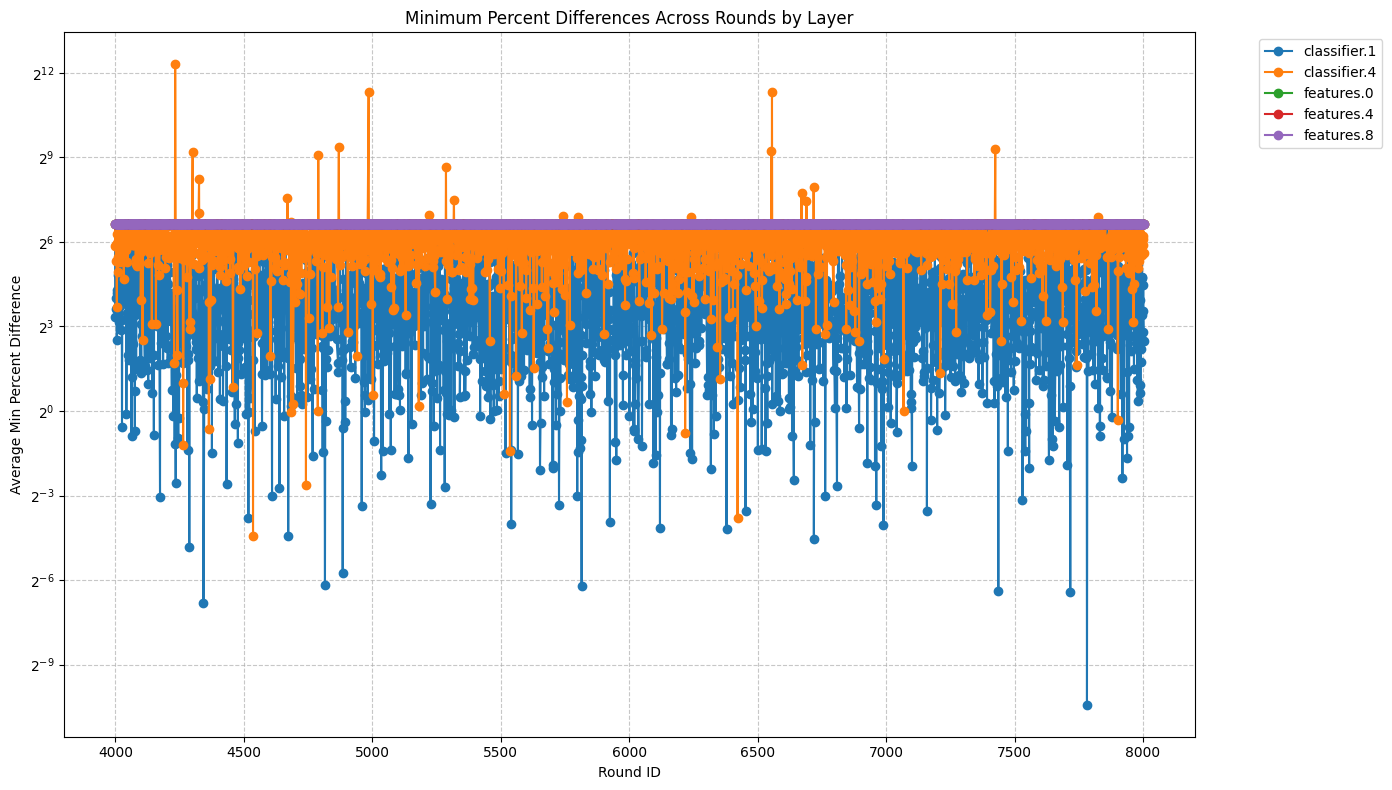

In [35]:
diff = df.groupby(['input_id','layer_name'])['percent_difference'].min()

diff_df = diff.reset_index()

pivot_diff = diff_df.pivot_table(
    values='percent_difference', 
    index='layer_name', 
    columns='input_id', 
    aggfunc='min'  # Average across all inputs
)

# 2. Line plot showing trends across rounds for each layer
fig, ax = plt.subplots(figsize=(14, 8))
for layer in diff_df['layer_name'].unique():
    layer_data = diff_df[diff_df['layer_name'] == layer]
    layer_avg = layer_data.groupby('input_id')['percent_difference'].mean()
    ax.plot(layer_avg.index, layer_avg.values, marker='o', label=layer)

ax.set_title('Minimum Percent Differences Across Rounds by Layer')
ax.set_xlabel('Round ID')
ax.set_ylabel('Average Min Percent Difference')
ax.set_yscale('log', base=2)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('min_percent_diff_trends.png', dpi=300)

plt.show()

In [23]:
diff.T

input_id  round_id  layer_name  
4000      0         classifier.1     56.668265
                    classifier.4     57.413599
                    features.0      100.000000
                    features.4      100.000000
                    features.8       99.999997
                                       ...    
8004      49        classifier.1    460.925021
                    classifier.4     49.134264
                    features.0      100.000000
                    features.4      100.000000
                    features.8      100.000000
Name: percent_difference, Length: 696650, dtype: float64

C:\Users\hskay\AppData\Local\Temp\ipykernel_6660\2643839080.py:128: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


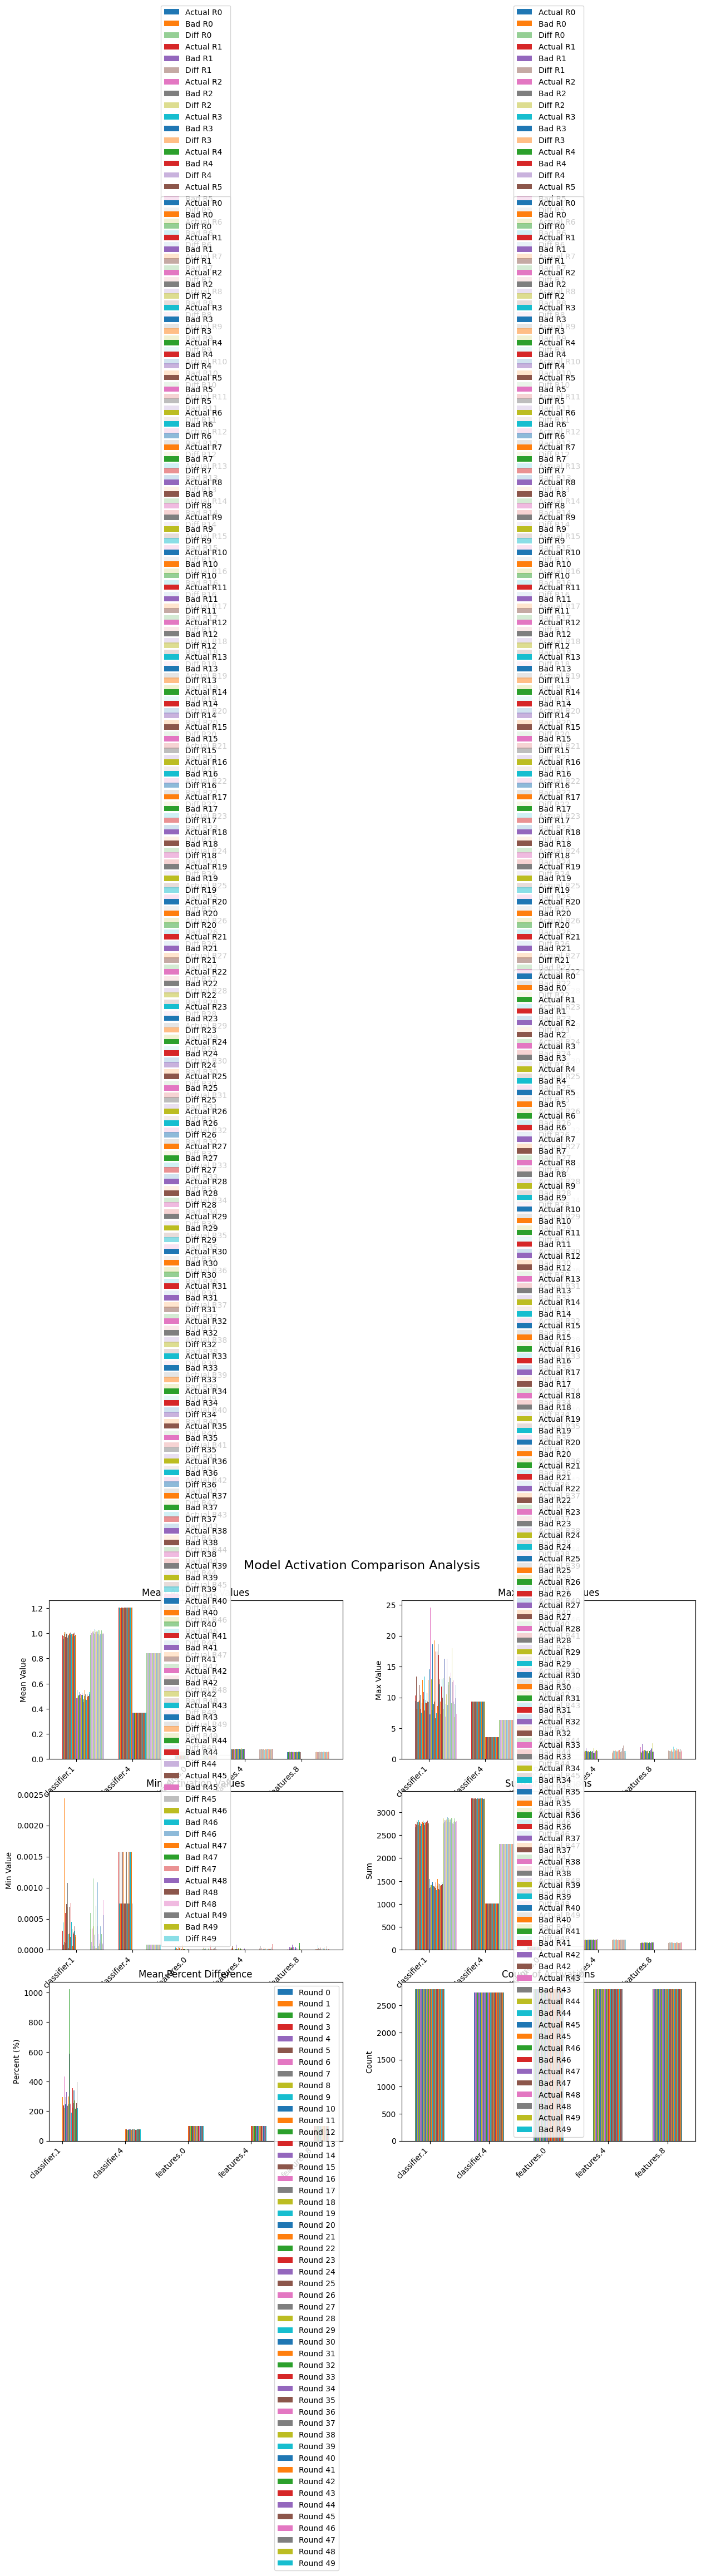


Numerical Differences (Actual - Bad Model) by Layer and Round:

Layer: features.0
  Round 0:
    Mean Activation Difference: 0.0596
    Max Activation Difference: 0.8423
    Min Activation Difference: 0.0000
    Sum Activation Difference: 166.6801
    Mean Percent Difference: 100.00%
  Round 1:
    Mean Activation Difference: 0.0583
    Max Activation Difference: 0.8316
    Min Activation Difference: 0.0000
    Sum Activation Difference: 163.1342
    Mean Percent Difference: 100.00%
  Round 2:
    Mean Activation Difference: 0.0591
    Max Activation Difference: 0.8006
    Min Activation Difference: 0.0000
    Sum Activation Difference: 165.3744
    Mean Percent Difference: 100.00%
  Round 3:
    Mean Activation Difference: 0.0617
    Max Activation Difference: 0.9425
    Min Activation Difference: 0.0000
    Sum Activation Difference: 172.5765
    Mean Percent Difference: 100.00%
  Round 4:
    Mean Activation Difference: 0.0577
    Max Activation Difference: 0.8666
    Min Activatio

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in a DataFrame called 'df'
# First, let's group by layer_name and round_id
grouped = df.groupby(['layer_name', 'round_id']).agg({
    'actual_activation': ['mean', 'min', 'max', 'sum', 'count'],
    'bad_model_activation': ['mean', 'min', 'max', 'sum', 'count'],
    'difference': ['mean', 'min', 'max', 'sum'],
    'percent_difference': 'mean'
})

# Flatten the column hierarchy
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
grouped = grouped.reset_index()

# Save the grouped statistics
grouped.to_csv('activation_comparison_by_layer_and_round.csv')

# Get unique layers and rounds for plotting
layers = df['layer_name'].unique()
rounds = df['round_id'].unique()

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Model Activation Comparison Analysis', fontsize=16)

# For each round, we'll create grouped bar charts
for round_id in rounds:
    round_data = grouped[grouped['round_id'] == round_id]
    
    # Set width and positions for bars
    width = 0.25
    x = np.arange(len(round_data))
    
    # 1. Mean Activation Values
    ax1 = axes[0, 0]
    ax1.bar(x - width + (round_id * width/len(rounds)), round_data['actual_activation_mean'], 
            width/len(rounds), label=f'Actual R{round_id}')
    ax1.bar(x + (round_id * width/len(rounds)), round_data['bad_model_activation_mean'], 
            width/len(rounds), label=f'Bad R{round_id}')
    ax1.bar(x + width + (round_id * width/len(rounds)), round_data['difference_mean'], 
            width/len(rounds), label=f'Diff R{round_id}', alpha=0.5)
    
    if round_id == rounds[-1]:  # Only set these once after the last round
        ax1.set_xticks(x)
        ax1.set_xticklabels(round_data['layer_name'], rotation=45, ha='right')
        ax1.set_title('Mean Activation Values')
        ax1.set_ylabel('Mean Value')
        ax1.legend()
    
    # 2. Max Activation Values
    ax2 = axes[0, 1]
    ax2.bar(x - width + (round_id * width/len(rounds)), round_data['actual_activation_max'], 
            width/len(rounds), label=f'Actual R{round_id}')
    ax2.bar(x + (round_id * width/len(rounds)), round_data['bad_model_activation_max'], 
            width/len(rounds), label=f'Bad R{round_id}')
    ax2.bar(x + width + (round_id * width/len(rounds)), round_data['difference_max'], 
            width/len(rounds), label=f'Diff R{round_id}', alpha=0.5)
    
    if round_id == rounds[-1]:
        ax2.set_xticks(x)
        ax2.set_xticklabels(round_data['layer_name'], rotation=45, ha='right')
        ax2.set_title('Max Activation Values')
        ax2.set_ylabel('Max Value')
        ax2.legend()
    
    # 3. Min Activation Values
    ax3 = axes[1, 0]
    ax3.bar(x - width + (round_id * width/len(rounds)), round_data['actual_activation_min'], 
            width/len(rounds), label=f'Actual R{round_id}')
    ax3.bar(x + (round_id * width/len(rounds)), round_data['bad_model_activation_min'], 
            width/len(rounds), label=f'Bad R{round_id}')
    ax3.bar(x + width + (round_id * width/len(rounds)), round_data['difference_min'], 
            width/len(rounds), label=f'Diff R{round_id}', alpha=0.5)
    
    if round_id == rounds[-1]:
        ax3.set_xticks(x)
        ax3.set_xticklabels(round_data['layer_name'], rotation=45, ha='right')
        ax3.set_title('Min Activation Values')
        ax3.set_ylabel('Min Value')
        ax3.legend()
    
    # 4. Sum of Activations
    ax4 = axes[1, 1]
    ax4.bar(x - width + (round_id * width/len(rounds)), round_data['actual_activation_sum'], 
            width/len(rounds), label=f'Actual R{round_id}')
    ax4.bar(x + (round_id * width/len(rounds)), round_data['bad_model_activation_sum'], 
            width/len(rounds), label=f'Bad R{round_id}')
    ax4.bar(x + width + (round_id * width/len(rounds)), round_data['difference_sum'], 
            width/len(rounds), label=f'Diff R{round_id}', alpha=0.5)
    
    if round_id == rounds[-1]:
        ax4.set_xticks(x)
        ax4.set_xticklabels(round_data['layer_name'], rotation=45, ha='right')
        ax4.set_title('Sum of Activations')
        ax4.set_ylabel('Sum')
        ax4.legend()
    
    # 5. Percent Difference
    ax5 = axes[2, 0]
    ax5.bar(x + (round_id * width/len(rounds)), round_data['percent_difference_mean'], 
            width/len(rounds), label=f'Round {round_id}')
    
    if round_id == rounds[-1]:
        ax5.set_xticks(x)
        ax5.set_xticklabels(round_data['layer_name'], rotation=45, ha='right')
        ax5.set_title('Mean Percent Difference')
        ax5.set_ylabel('Percent (%)')
        ax5.legend()
    
    # 6. Count Comparison (if available)
    ax6 = axes[2, 1]
    ax6.bar(x - width + (round_id * width/len(rounds)), round_data['actual_activation_count'], 
            width/len(rounds), label=f'Actual R{round_id}')
    ax6.bar(x + (round_id * width/len(rounds)), round_data['bad_model_activation_count'], 
            width/len(rounds), label=f'Bad R{round_id}')
    
    if round_id == rounds[-1]:
        ax6.set_xticks(x)
        ax6.set_xticklabels(round_data['layer_name'], rotation=45, ha='right')
        ax6.set_title('Count of Activations')
        ax6.set_ylabel('Count')
        ax6.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('activation_comparison_analysis.png', dpi=300)
plt.show()

# Print numerical differences by layer and round
print("\nNumerical Differences (Actual - Bad Model) by Layer and Round:")
print("=" * 80)
for layer in layers:
    print(f"\nLayer: {layer}")
    for round_id in rounds:
        layer_round_data = grouped[(grouped['layer_name'] == layer) & (grouped['round_id'] == round_id)]
        if not layer_round_data.empty:
            print(f"  Round {round_id}:")
            print(f"    Mean Activation Difference: {layer_round_data['difference_mean'].values[0]:.4f}")
            print(f"    Max Activation Difference: {layer_round_data['difference_max'].values[0]:.4f}")
            print(f"    Min Activation Difference: {layer_round_data['difference_min'].values[0]:.4f}")
            print(f"    Sum Activation Difference: {layer_round_data['difference_sum'].values[0]:.4f}")
            print(f"    Mean Percent Difference: {layer_round_data['percent_difference_mean'].values[0]:.2f}%")


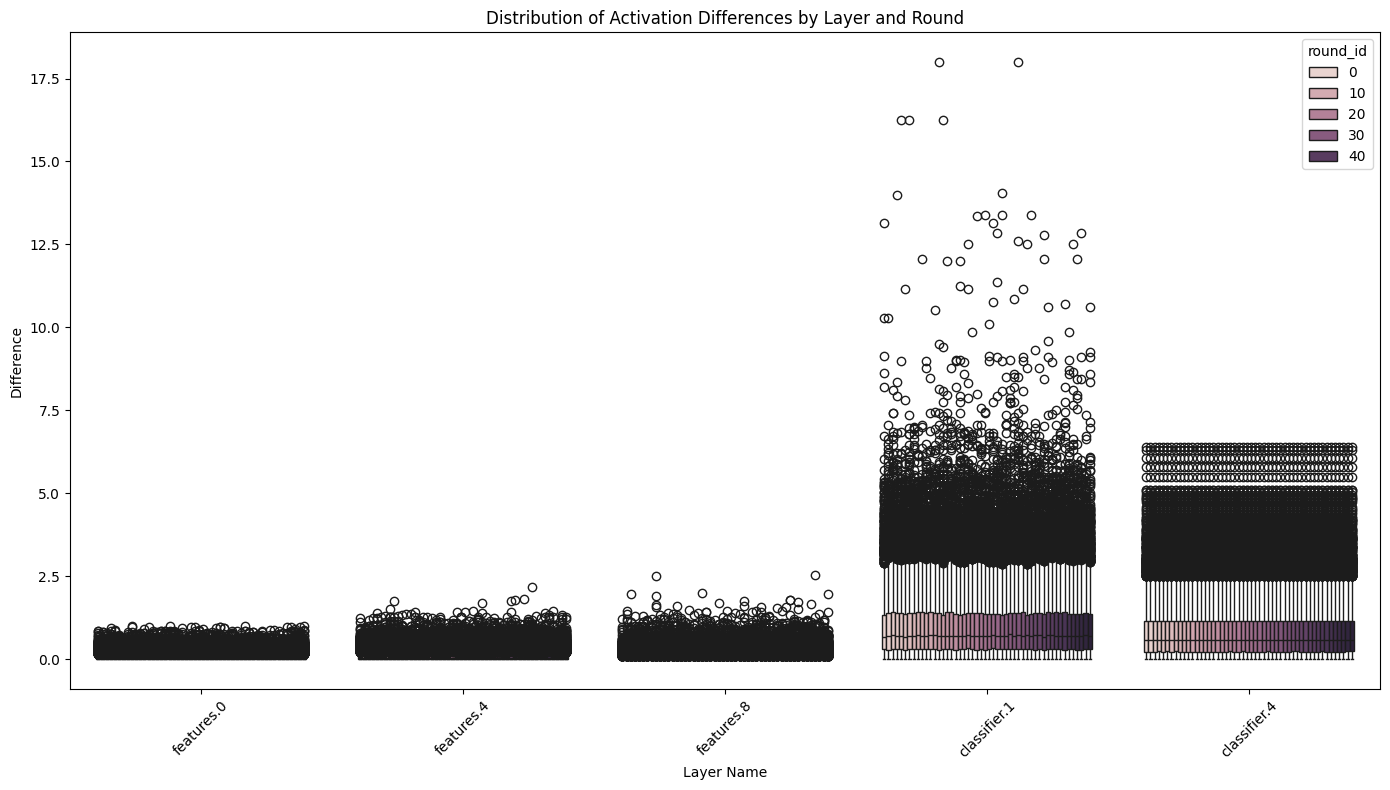

In [ ]:
# grouped_data = df.groupby(['layer_name', 'round_id']).agg({
#     'difference': ['mean', 'min', 'max'],
#     'percent_difference': 'mean'
# }).reset_index()

# plt.figure(figsize=(14, 8))
# sns.boxplot(x='layer_name', y='difference', hue='round_id', data=df)
# plt.title('Distribution of Activation Differences by Layer and Round')
# plt.xlabel('Layer Name')
# plt.ylabel('Difference')
# plt.xticks(rotation=45)
# plt.
# plt.tight_layout()
# plt.show()

In [ ]:
# Convert numeric columns to float
numeric_cols = ['actual_activation', 'bad_model_activation', 'difference', 
                'percent_difference', 'layer_mean_difference', 
                'layer_max_difference', 'layer_min_difference']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Get unique input_ids and round_ids
input_ids = df['input_id'].unique()
round_ids = df['round_id'].unique()

# Create figure with multiple subplots
fig = plt.figure(figsize=(15, 12))

# 1. Layer-wise mean differences
plt.subplot(2, 2, 1)
sns.barplot(x='layer_name', y='difference', data=df.dropna(subset=['difference']))
plt.title('Activation Differences by Layer')
plt.xlabel('Layer')
plt.ylabel('Difference (Model_1 - Model_2)')
plt.xticks(rotation=45, ha='right')

# 2. Percentage differences across layers
plt.subplot(2, 2, 2)
sns.boxplot(x='layer_name', y='percent_difference', data=df.dropna(subset=['percent_difference']))
plt.title('Percentage Differences by Layer')
plt.xlabel('Layer')
plt.ylabel('Percent Difference (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 110)  # Percentage should be between 0-100%

# 3. Actual vs Bad Model Activations
plt.subplot(2, 2, 3)

# Get layers with valid data for both activations
valid_layers = df.dropna(subset=['actual_activation', 'bad_model_activation'])

if not valid_layers.empty:
    # Group by layer and calculate mean activations
    layer_means = valid_layers.groupby('layer_name').agg({
        'actual_activation': 'mean',
        'bad_model_activation': 'mean'
    }).reset_index()
    
    # Set up bar positions
    x = np.arange(len(layer_means))
    width = 0.35
    
    # Create grouped bar chart
    plt.bar(x - width/2, layer_means['actual_activation'], width, label='Model_1 Activation')
    plt.bar(x + width/2, layer_means['bad_model_activation'], width, label='Model_2 Activation')
    
    plt.xlabel('Layer')
    plt.ylabel('Mean Activation')
    plt.title('Mean Activations: Model_1 vs Model_2')
    plt.xticks(x, layer_means['layer_name'], rotation=45, ha='right')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No valid activation data available', 
                horizontalalignment='center', verticalalignment='center')

# 4. Heatmap of differences across layers and inputs/rounds
plt.subplot(2, 2, 4)

# If we have multiple inputs or rounds, create a heatmap
if len(input_ids) > 1 or len(round_ids) > 1:
    # Create a pivot table
    if len(input_ids) > 1 and len(round_ids) > 1:
        pivot_df = df.pivot_table(
            values='difference', 
            index='layer_name', 
            columns=['input_id', 'round_id'],
            aggfunc='mean'
        )
    elif len(input_ids) > 1:
        pivot_df = df.pivot_table(
            values='difference', 
            index='layer_name', 
            columns='input_id',
            aggfunc='mean'
        )
    else:
        pivot_df = df.pivot_table(
            values='difference', 
            index='layer_name', 
            columns='round_id',
            aggfunc='mean'
        )
    
    sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title('Differences Across Inputs/Rounds')
else:
    # If only one input/round, show distribution of differences
    sns.histplot(df['difference'].dropna(), kde=True)
    plt.title('Distribution of Activation Differences')
    plt.xlabel('Difference')
    plt.ylabel('Count')

plt.tight_layout()

plt.suptitle('Model Comparison Visualization', fontsize=16, y=1.02)

plt.savefig('model_comparison_visualization.png', bbox_inches='tight', dpi=300)
print("Visualization saved as 'model_comparison_visualization.png'")
plt.show()


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002F378F01D00> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 